# Hierarchical Compression Analysis

This notebook demonstrates how hierarchical compression can achieve better compression ratios through repeated compression, even when compared to single compression with larger vocabularies.

We call the compression "HierarchicalLZCoder". Probably there is a better name.

We compare a bit with an "LZ" coder, which is just:
1. maintain a dictionary of prefixes.
2. look in the input for the shortest prefix that is NOT in the dictionary.
3. Add that prefix to the dictionary if the dictionary is less than the maximum dictionary size.
4. Output the index of the longest matching prefix (which might be the one just added), and remove it from the input stream.

Our approach just maintains a bunch of these LZ coder things in parallel, one for each possible output symbol. There is one other trick: when choosing which output symbol to associate with a newly-added prefix in one of the LZ coders, we ask all the *other* LZ coders that are not currently active what their best matching symbol is, and we choose the most popular available option.


In [1]:
from src.lz import LZCoder, HierachicalLZCoder, ensure_list
import math
import matplotlib.pyplot as plt
import numpy as np

## Load Test Text

First, let's load our test text that we'll use for compression analysis.

In [2]:
with open('test/compression_test_text.txt', 'r') as f:
    test_text = f.read().strip()

print(f"Text length: {len(test_text)} characters")
print("\nFirst 200 characters:")
print(test_text[:200] + "...")

Text length: 4776 characters

First 200 characters:
this is some awesome test here, I am really quite amazed. 
In particular, we are going to get some reasonable compression 
even though our encoding vocab size is only one more than the input vocab siz...


## Initial Compression

Let's perform the first level of compression using our hierarchical encoder.

In [3]:
# Convert text to list of bytes
to_encode_list = ensure_list(test_text)
input_vocab = set(to_encode_list)

# Create and apply first level compression
coder = HierachicalLZCoder(output_vocab_size=len(input_vocab), input_vocab=input_vocab)
encoded = coder.encode(to_encode_list, learn=True)

# Calculate bit length
encoded_length = len(encoded) * math.log(len(input_vocab)+1, 2)
original_length = len(to_encode_list) * math.log(len(input_vocab), 2)

print(f"Original text length (bits): {original_length:.2f}")
print(f"First compression length (bits): {encoded_length:.2f}")
print(f"Compression ratio: {original_length/encoded_length:.2f}x")
print(f"\nFirst level vocabulary size: {len(input_vocab)}")
print(f"First level encoded vocabulary size: {len(set(encoded))}")

Original text length (bits): 26955.06
First compression length (bits): 15219.12
Compression ratio: 1.77x

First level vocabulary size: 50
First level encoded vocabulary size: 51


## Second Level Compression

Now let's compress the already compressed data with a larger vocabulary.

In [4]:
# Get vocabulary from first compression
encoded_vocab = set(encoded)

# Create and apply second level compression
second_coder = HierachicalLZCoder(output_vocab_size=2*len(encoded_vocab), input_vocab=encoded_vocab)
second_encoded = second_coder.encode(encoded, learn=True)

# Calculate bit length
second_encoded_length = len(second_encoded) * math.log(2*len(encoded_vocab)+1, 2)

print(f"Second compression length (bits): {second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/second_encoded_length:.2f}x")
print(f"\nSecond level vocabulary size: {len(encoded_vocab)}")
print(f"Second level encoded vocabulary size: {len(set(second_encoded))}")

Second compression length (bits): 13419.81
Total compression ratio: 2.01x

Second level vocabulary size: 51
Second level encoded vocabulary size: 52


## Comparison with Single Compression

Let's compare our results with a single compression using a larger vocabulary.

In [5]:
# Try single compression with double vocabulary
double_vocab_size = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=input_vocab)
double_vocab_size_encoded = double_vocab_size.encode(to_encode_list, learn=True)
double_vocab_size_encoded_length = len(double_vocab_size_encoded) * math.log(2*len(input_vocab)+1, 2)

# Try LZ compression with large vocabulary
lz_coder = LZCoder(output_vocab_size=10*len(input_vocab)+1, input_vocab=input_vocab)
lz_encoded = lz_coder.encode(test_text, learn=True)
lz_encoded_length = len(lz_encoded) * math.log(10*len(input_vocab)+1, 2)

print(f"Single compression with double vocabulary (bits): {double_vocab_size_encoded_length:.2f}")
print(f"LZ compression with 10x vocabulary (bits): {lz_encoded_length:.2f}")
print(f"\nDouble compression (bits): {second_encoded_length:.2f}")

Single compression with double vocabulary (bits): 18350.03
LZ compression with 10x vocabulary (bits): 18358.86

Double compression (bits): 13419.81


## Unconstrained LZ Compression

Let's see how the basic LZ coder performs when we don't limit its vocabulary size.

In [6]:
# Create LZ coder with unlimited vocabulary
unlimited_lz_coder = LZCoder(output_vocab_size=1000000, input_vocab=input_vocab)
unlimited_lz_encoded = unlimited_lz_coder.encode(test_text, learn=True)
unlimited_lz_encoded_length = len(unlimited_lz_encoded) * math.log(len(unlimited_lz_coder.encoded_vocab), 2)

print(f"Unlimited LZ compression length (bits): {unlimited_lz_encoded_length:.2f}")
print(f"Compression ratio: {original_length/unlimited_lz_encoded_length:.2f}x")
print(f"\nUnlimited LZ vocabulary size: {len(set(unlimited_lz_encoded))}")

Unlimited LZ compression length (bits): 15073.19
Compression ratio: 1.79x

Unlimited LZ vocabulary size: 1431


## Hierarchical Compression with Larger First Level

Let's try hierarchical compression starting with a larger vocabulary in the first level.

In [7]:
# Create first level coder with double vocabulary
double_first_coder = HierachicalLZCoder(output_vocab_size=2*len(input_vocab), input_vocab=input_vocab)
double_first_encoded = double_first_coder.encode(to_encode_list, learn=True)
double_first_encoded_length = len(double_first_encoded) * math.log(2*len(input_vocab)+1, 2)

# Get vocabulary from first compression
double_first_vocab = set(double_first_encoded)

# Create and apply second level compression
double_second_coder = HierachicalLZCoder(output_vocab_size=2*len(double_first_vocab), input_vocab=double_first_vocab)
double_second_encoded = double_second_coder.encode(double_first_encoded, learn=True)
double_second_encoded_length = len(double_second_encoded) * math.log(2*len(double_first_vocab)+1, 2)

print(f"First level with double vocabulary (bits): {double_first_encoded_length:.2f}")
print(f"Second level compression (bits): {double_second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/double_second_encoded_length:.2f}x")
print(f"\nFirst level vocabulary size: {len(double_first_vocab)}")
print(f"Second level vocabulary size: {len(set(double_second_encoded))}")

First level with double vocabulary (bits): 18350.03
Second level compression (bits): 15957.05
Total compression ratio: 1.69x

First level vocabulary size: 53
Second level vocabulary size: 54


## LZ First Level with Hierarchical Second Level

Let's explore using LZ compression for the first level, followed by hierarchical compression.

In [8]:
# First level LZ compression
lz_first_coder = LZCoder(output_vocab_size=10*len(input_vocab)+1, input_vocab=input_vocab)
lz_first_encoded = lz_first_coder.encode(test_text, learn=True)
lz_first_encoded_length = len(lz_first_encoded) * math.log(10*len(input_vocab)+1, 2)

# Get vocabulary from LZ compression
lz_first_vocab = set(lz_first_encoded)

# Create and apply hierarchical second level compression
lz_second_coder = HierachicalLZCoder(output_vocab_size=2*len(lz_first_vocab), input_vocab=lz_first_vocab)
lz_second_encoded = lz_second_coder.encode(lz_first_encoded, learn=True)
lz_second_encoded_length = len(lz_second_encoded) * math.log(2*len(lz_first_vocab)+1, 2)

print(f"LZ first level compression (bits): {lz_first_encoded_length:.2f}")
print(f"Hierarchical second level (bits): {lz_second_encoded_length:.2f}")
print(f"Total compression ratio: {original_length/lz_second_encoded_length:.2f}x")
print(f"\nLZ first level vocabulary size: {len(lz_first_vocab)}")
print(f"Second level vocabulary size: {len(set(lz_second_encoded))}")

LZ first level compression (bits): 18358.86
Hierarchical second level (bits): 16840.10
Total compression ratio: 1.60x

LZ first level vocabulary size: 489
Second level vocabulary size: 490


## Updated Visualization

Let's update our visualization to include all compression methods.

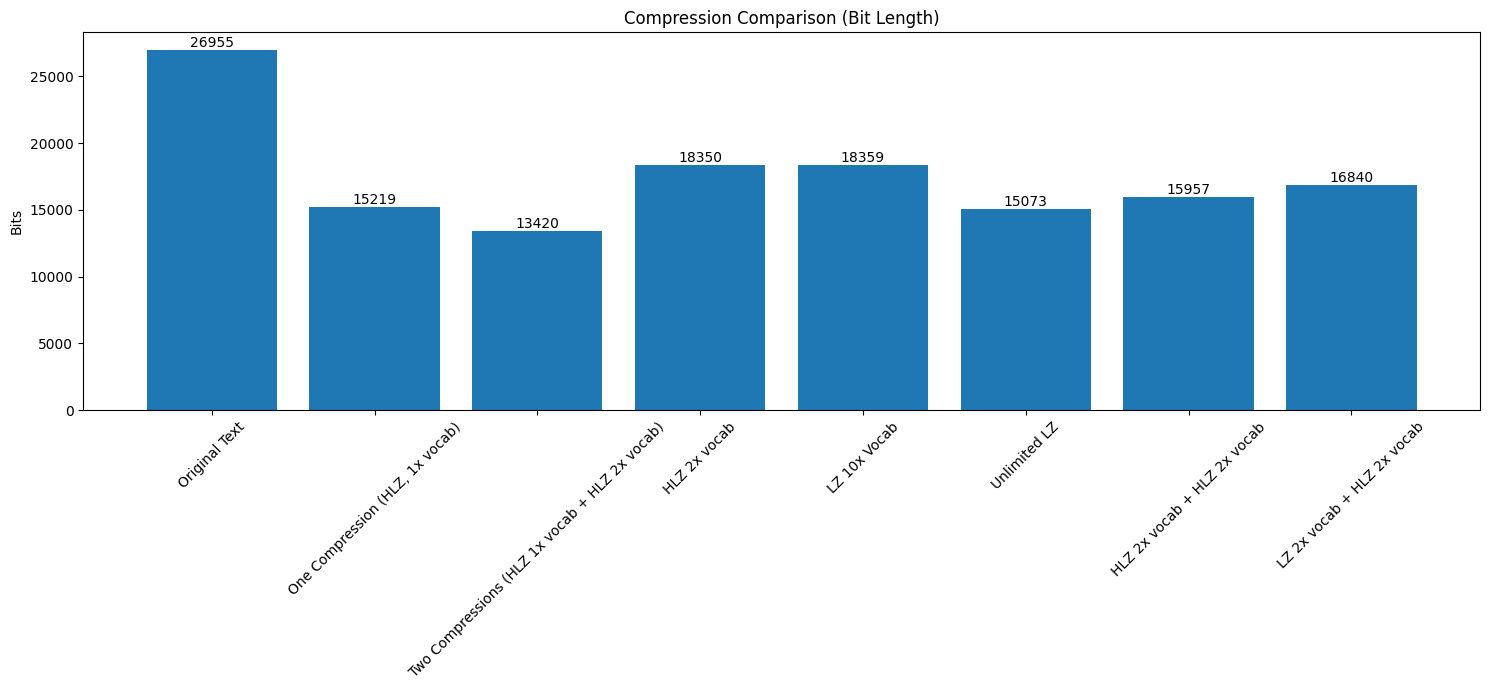


Compression Ratios:
Original Text: 1.00x
One Compression (HLZ, 1x vocab): 1.77x
Two Compressions (HLZ 1x vocab + HLZ 2x vocab): 2.01x
HLZ 2x vocab: 1.47x
LZ 10x Vocab: 1.47x
Unlimited LZ: 1.79x
HLZ 2x vocab + HLZ 2x vocab: 1.69x
LZ 2x vocab + HLZ 2x vocab: 1.60x


In [9]:
# Prepare data for plotting
methods = ['Original Text', 'One Compression (HLZ, 1x vocab)', 'Two Compressions (HLZ 1x vocab + HLZ 2x vocab)', 'HLZ 2x vocab', 'LZ 10x Vocab',
          'Unlimited LZ', 'HLZ 2x vocab + HLZ 2x vocab', 'LZ 2x vocab + HLZ 2x vocab']
bit_lengths = [original_length, encoded_length, second_encoded_length, 
              double_vocab_size_encoded_length, lz_encoded_length,
              unlimited_lz_encoded_length, double_second_encoded_length, lz_second_encoded_length]

# Create bar plot
plt.figure(figsize=(15, 7))
bars = plt.bar(methods, bit_lengths)
plt.title('Compression Comparison (Bit Length)')
plt.ylabel('Bits')
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate and display compression ratios
ratios = [original_length/l for l in bit_lengths]
print("\nCompression Ratios:")
for method, ratio in zip(methods, ratios):
    print(f"{method}: {ratio:.2f}x")

## Extended Analysis

The additional experiments reveal:
1. Even with an unlimited vocabulary, the basic LZ coder doesn't achieve the same compression as hierarchical methods
2. Starting with a larger vocabulary in the first level of hierarchical compression can improve overall compression
3. Using LZ compression as the first level followed by hierarchical compression shows interesting trade-offs
4. The hierarchical approach seems to possibly work when composed with itself, but not with LZ.